# Classification under additive Gaussian noise

In [22]:
import h5py

import numpy as np

from qutip.wigner import qfunc
from qutip import coherent

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from qst_nn.models.classifier import Classifier
from qst_nn.data.preprocess import remove_data, remap_labels, normalize
from qst_nn.training.train_classifier import loss, optimizer
from qst_nn.utils import plot_three_husimi, cat

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

from tqdm.auto import tqdm


from sklearn.metrics import roc_auc_score, accuracy_score

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = ""
tf.keras.backend.set_floatx('float32')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
# https://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html
fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = {# 'backend': 'ps',
          'axes.labelsize': 8,
          'font.size': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'axes.labelpad': 1,
          'text.usetex': False,
          'figure.figsize': fig_size,}
plt.rcParams.update(params)
figpath = "figures/"

# Visualize what adding Gaussian noise to a cat does to the data

In [44]:
hilbert_size = 32
xgrid, ygrid = 32, 32

xvec = np.linspace(-5, 5, xgrid)
yvec = np.linspace(-5, 5, ygrid)

rho = cat(hilbert_size, 2, 0, 0)
sigmas = np.linspace(0., 1, 200)


def add_noise(im, sigma):
    """Adds Gaussian noise to an image.

    Args:
        im (array): An image of shape (n, n). 
        sigma (float): The value of the variance for Gaussian noise.

    Returns:
        array: The image with added Gaussian noise.
    """
    im = im/np.max(im)
    im = tf.keras.layers.GaussianNoise(sigma)(im, training=True)
    im = im.numpy()
    return im


im = qfunc(rho, xvec, yvec, g=2)
x = np.array([add_noise(im, sigma) for sigma in sigmas])

/var/folders/8s/tfpsk_fx609f8w7z__yzz9vh0000gn/T/ipykernel_27695/238565704.py:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolor(xvec, yvec, im/np.max(im), vmin=0, vmax=1, cmap="hot")


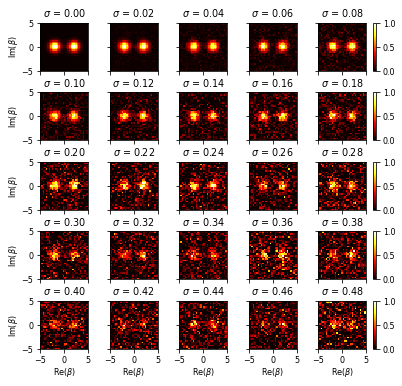

In [45]:
image_grid_size = 5
num_images = 25

# Select a bunch of random indices to get grid x grid images for plotting
rand_indices = np.arange(0, x.shape[0], 4)
images = x[rand_indices]
labels = [r"$\sigma$ = {:.2f}".format(sigmas[i]) for i in rand_indices]


fig = plt.figure(figsize=(10, 6), constrained_layout=False)
image_grid = ImageGrid(fig, 111,  # similar to subplot(111)
                       nrows_ncols=(image_grid_size, image_grid_size),
                       cbar_mode="edge",
                       cbar_pad = 0.1,
                       axes_pad=0.3,)
                 

for i in range(num_images):
    ax, im, label = image_grid[i], images[i], labels[i]

    im = ax.pcolor(xvec, yvec, im/np.max(im), vmin=0, vmax=1, cmap="hot")
    ax.set_title(label)
    ax.cax.colorbar(im, ticks=[0, 0.5, 1])
    ax.set_ylabel(r"Im($\beta$)")
    ax.set_xlabel(r"Re($\beta$)")

plt.show()

# Load the classifier and make predictions on the data

In [46]:
classifier = Classifier()
classifier.compile(optimizer=optimizer,
                   loss=loss,
                   metrics=['accuracy'])



# Create a callback that saves the model's weights
checkpoint_path = "classifier/"
checkpoint_dir = os.path.dirname(checkpoint_path)
classifier.load_weights(checkpoint_path)


# Predict probabilities for different classes for the generated data

In [47]:
pred = classifier.predict(x.reshape((-1, 32, 32, 1)))
probabilities_softmax = tf.keras.activations.softmax(tf.convert_to_tensor(pred))

# Predicted probabilities for each of the seven classes

print(probabilities_softmax.shape) 

(200, 7)


# Plot probabilites

### We see that upto $\sigma = 0.2$, the predictions are still a cat

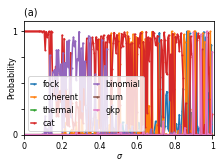

In [48]:
reverse_mapping_correct = {
          0:"fock",
         1:"coherent",
         2:"thermal",
         3:"cat",
         4:"binomial",
         5:"num",
         6:"gkp"
          }

fig, ax1 = plt.subplots(1, 1, figsize=(fig_width, fig_height))

xlist = sigmas.ravel()
mean = probabilities_softmax

for i in range(7):
    ax1.plot(xlist, mean[:, i], "-o", alpha = 1, markersize=1,
             label="{}".format(reverse_mapping_correct[i]))
    # ax1.fill_between(xlist, mean[:, i] - std[:, i],
    #                 mean[:, i] + std[:, i], alpha=0.1)

ax1.legend(loc="lower left", ncol=2, handlelength=.6)
# ax1.grid(alpha=0.3)

ax1.set_xlabel(r"$\sigma$",)
ax1.set_ylabel(r"Probability", labelpad=-4,)


ax1.set_ylim(-0.001, 1.1)
ax1.set_xlim(-0.001, 1.01)
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.])

ax1.set_yticklabels([0, "", "", "", 1])
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

ax1.set_aspect(0.55)
# ax1.set_title(r"(a)", loc="left")
ax1.set_title("(a)                                                           ")
# ax1.text(0.02, .83, "(a)")

plt.show()

# Plot ROC curves and accuracy for the entire test data

The requires either the full test data file (~1.8 GB), or generating different,
states, adding noise to them and making predictions. Then you can use
the code below to reproduce Fig 9 from the paper.

Please contact "shahnawaz.ahmed95@gmail.com" for the full data files.

In [49]:
xgrid = 32
ygrid = 32

xvec = np.linspace(-5, 5, xgrid)
yvec = np.linspace(-5, 5, ygrid)


datapath = "data/"

with h5py.File(datapath+"test.h5", 'r') as f:
    xdata_test = f["x"][()]
    ydata_test = f["y"][()]
    
# Data shapes
print("Test x-data shape", xdata_test.shape)
print("Test y-data shape", ydata_test.shape)

xdata_test, ydata_test = remove_data(xdata_test, ydata_test, 3)
ydata_test = remap_labels(ydata_test)


# Any other preprocessing or removal of the data should be done before this step
x_test, y_test = xdata_test.reshape((-1, xgrid, ygrid, 1)), ydata_test.reshape((-1,1))

Test x-data shape (10000, 1024)
Test y-data shape (10000, 1)


# Predict for different values of sigma

In [53]:
predictions = []
batch_size = 256

mapping = {"fock":0,
         "coherent":1,
         "thermal":2,
         "cat":3,
          "binomial":4,
          "num":5,
          "gkp":6}

sigmas = np.linspace(0., 1, 25)

for sigma in tqdm(sigmas):
    test_data_generator = ImageDataGenerator(
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            samplewise_std_normalization=False,
                            samplewise_center=False,
                            rotation_range=0,
                            width_shift_range=0,
                            height_shift_range=0,
                            horizontal_flip=False,
                            vertical_flip=False,
                            shear_range=0,
                            zoom_range=0,
        preprocessing_function = lambda x: add_noise(x, sigma)
    )

    test_data_gen = test_data_generator.flow(x_test, y_test, batch_size=batch_size, shuffle=False)
    y_pred = classifier.predict(test_data_gen)
    
    predictions.append(y_pred)

In [9]:
auc_list = []
acc_list = []

for p, sigma in zip(predictions, sigmas):
    y_score = tf.nn.softmax(p).numpy()
    auc = roc_auc_score(y_test, y_score,
                  average='macro',
                  sample_weight=None,
                  max_fpr=None,
                  multi_class='ovr')
    
    accuracy = accuracy_score(y_test, np.argmax(y_score, 1))
    auc_list.append(auc)
    acc_list.append(accuracy)

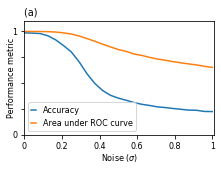

In [10]:
fig, ax1 = plt.subplots(1, 1, figsize=(fig_width, fig_height))

xlist = sigmas
ax1.plot(sigmas, acc_list, label="Accuracy")
ax1.plot(sigmas, auc_list, label="Area under ROC curve")

ax1.legend(loc="lower left", ncol=1, handlelength=.6)
# ax1.grid(alpha=0.3)

ax1.set_xlabel(r"Noise ($\sigma$)")
ax1.set_ylabel(r"Performance metric", labelpad=-4,)


ax1.set_ylim(-0.001, 1.1)
ax1.set_xlim(-0.001, 1.01)
ax1.set_yticks([0, 0.25, 0.5, 0.75, 1.])

ax1.set_yticklabels([0, "", "", "", 1])
ax1.set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
ax1.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1])

ax1.set_aspect(0.55)
ax1.set_title("(a)                                                           ")
plt.show()

In [11]:
print(sigmas[np.argwhere(np.array(acc_list) < 0.9)[0][0]])

0.20833333333333331


# Visualize a CAT state with additive Gaussian noise

In [12]:
psi = coherent(32, 2) + coherent(32, -2)
psi = psi.unit()
rho = psi*psi.dag()


im = qfunc(rho, xvec, yvec)

im1 = add_noise(im, 0.05)
im2 = add_noise(im, 0.20)

/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:234: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0].pcolor(xvec, yvec, d1,
/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:238: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[1].pcolor(xvec, yvec, d2,
/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:242: MatplotlibDeprecationWarning: shading='flat' when 

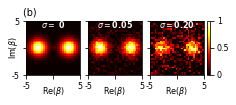

In [13]:
fig, ax = plot_three_husimi(im, im1, im2, title="(b)                                                           ",
                           cmap="hot")

titles = [r"$\sigma = $ 0", r"$\sigma = $0.05", r"$\sigma = $0.20"]


textcolor= "white"

ax[0].text(0.5, 0.88, titles[0], fontweight="bold", ha='center', 
          transform=ax[0].transAxes, fontsize=8, color="w",)

ax[1].text(0.5, 0.88, titles[1], fontweight="bold", ha='center', 
          transform=ax[1].transAxes, fontsize=8, color="w",)

ax[2].text(0.5, 0.88, titles[2],fontweight="bold", ha='center', 
          transform=ax[2].transAxes, fontsize=8, color="w",)
plt.savefig(figpath+"fig-9b-gaussian-results.pdf", bbox_inches="tight", pad_inches=0)